# Dependencies

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Model development and training

In [2]:
train_features_path = 'data/features_train.csv'
test_features_path = 'data/features_test.csv'
train_dataset = pd.read_csv(train_features_path)
test_dataset = pd.read_csv(test_features_path)
train_dataset = pd.get_dummies(train_dataset, columns = ['race'])
test_dataset = pd.get_dummies(test_dataset, columns = ['race'])
y = train_dataset.battleneturl
X = train_dataset.drop(['battleneturl', 'playername'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 0)

In [3]:
rfc = RandomForestClassifier(n_estimators = 100)
rfc.fit(X_train, y_train)
print(rfc.score(X_test, y_test))

0.8562091503267973


Our random forest classifier achieved an 86.9% cross validation accuracy, meaning it predicted the correct player 86.9% of the time.

# Feature analysis

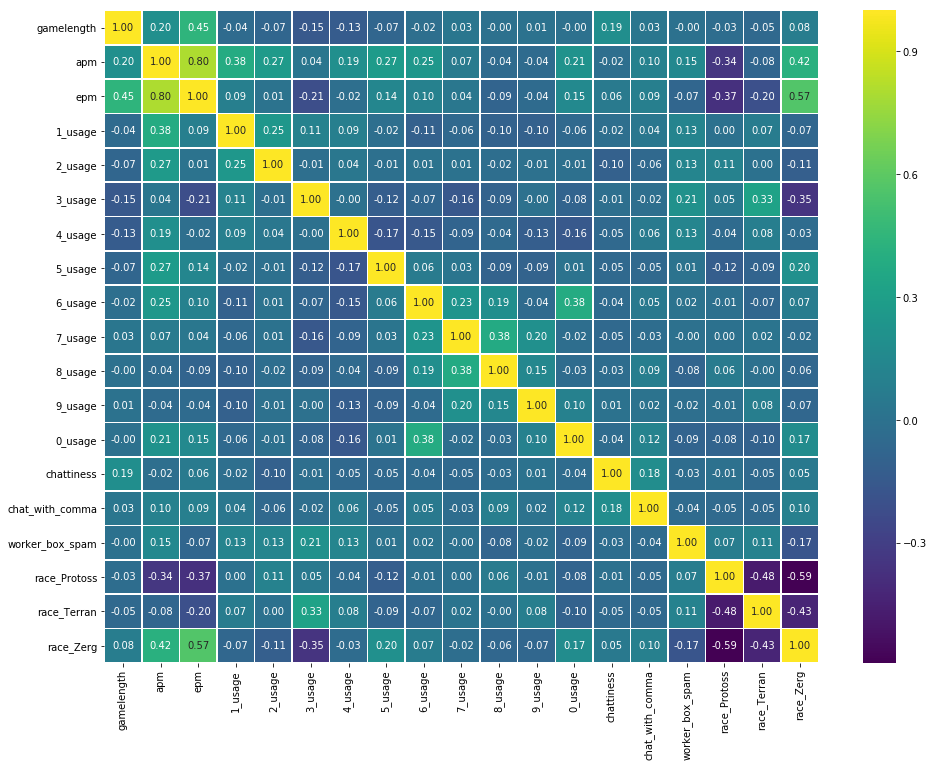

In [4]:
fig, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(train_dataset.corr(), annot=True, fmt='.2f', ax = ax, linewidths=0.5, cmap='viridis')
fig.savefig('output/correlations.png')

Most of our features extracted from the dataset are not strongly correlated, meaning we find new information from each of the different features. Of note, the race binary variables are strongly correlated with APM / EPM, which makes sense, as Protoss tends to have the lowest APM and Zerg tends to have the highest, simply due to how the races operate. 

# Player comparison - hotkeys

For a visual example of how different a player's hotkey signature can look from another player's, we will compare four different Zerg players: Dark, ByuL, Golden, and VortiX.

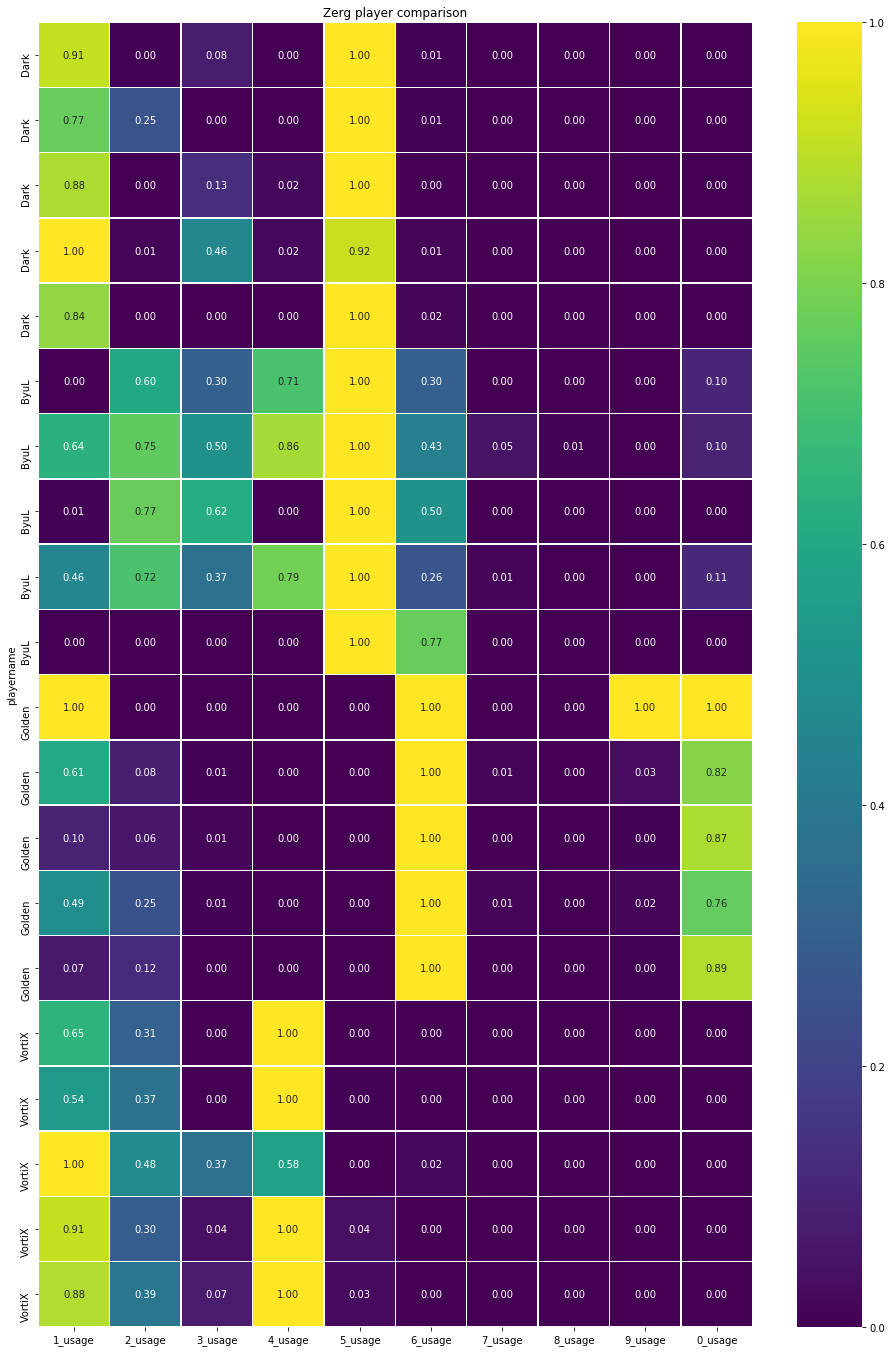

In [6]:
dark_games = train_dataset[train_dataset['playername'] == 'Dark'].sample(5).set_index('playername')

byul_games = train_dataset[train_dataset['playername'] == 'ByuL'].sample(5).set_index('playername')

golden_games = train_dataset[train_dataset['playername'] == 'Golden'].sample(5).set_index('playername')

vortix_games = train_dataset[train_dataset['playername'] == 'VortiX'].sample(5).set_index('playername')

# setup combined dataframe, scale each row so that maximum usage is 1.
hotkeys = [str(i) + '_usage' for i in [1, 2, 3, 4, 5, 6, 7, 8, 9, 0]]
all_games_zerg = [dark_games[hotkeys], byul_games[hotkeys], golden_games[hotkeys], vortix_games[hotkeys]]
combined_zerg = pd.concat(all_games_zerg)
combined_zerg = combined_zerg.div(combined_zerg.max(axis = 1), axis = 0)

fig, ax = plt.subplots(figsize=(16, 6 * len(all_games_zerg)))
sns.heatmap(combined_zerg, annot=True, fmt='.2f', ax = ax, linewidths=0.5, cmap='viridis')
plt.title('Zerg player comparison')
plt.savefig('output/zerg_comparison.png')
plt.show()

The above heatmap makes the differences between the players *very* obvious. Each player usually has a couple hotkeys that they use the most; this will usually be the hotkeys with the player's production buildings (for Zerg, their hatcheries), and their main army. We can see that Dark uses 1 and 5, ByuL uses 5, Golden uses 6 and 0, and VortiX uses 4. From there, we can identify lesser used hotkeys by each player to more precisely differentiate players. For example, although Dark and ByuL appear to have similar "main" hotkey usage, ByuL will also use his 2, 3, 4, and 6 hotkeys often, whereas Dark will *only* use 1 and 5 most of the time.

Let's compare some Protoss players as well.

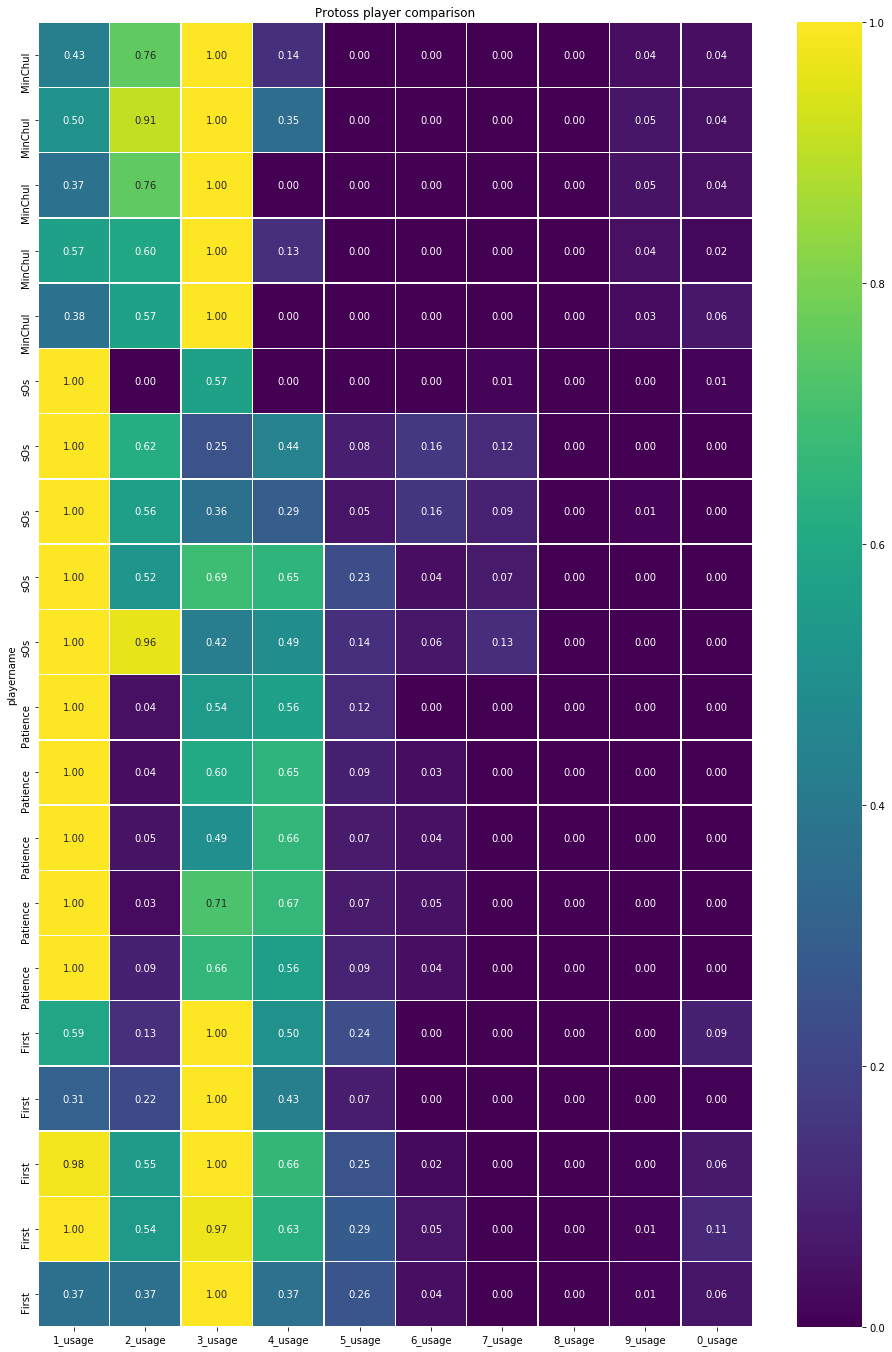

In [7]:
train_dataset[train_dataset['race_Protoss'] == 1]

mc_games = train_dataset[train_dataset['playername'] == 'MinChul'].sample(5).set_index('playername')

sos_games = train_dataset[train_dataset['playername'] == 'sOs'].sample(5).set_index('playername')

patience_games = train_dataset[train_dataset['playername'] == 'Patience'].sample(5).set_index('playername')

first_games = train_dataset[train_dataset['playername'] == 'First'].sample(5).set_index('playername')

# setup combined dataframe, scale each row so that maximum usage is 1.
hotkeys = [str(i) + '_usage' for i in [1, 2, 3, 4, 5, 6, 7, 8, 9, 0]]
all_games_protoss = [mc_games[hotkeys], sos_games[hotkeys], patience_games[hotkeys], first_games[hotkeys]]
combined_protoss = pd.concat(all_games_protoss)
combined_protoss = combined_protoss.div(combined_protoss.max(axis = 1), axis = 0)

fig, ax = plt.subplots(figsize=(16, 6 * len(all_games_protoss)))
sns.heatmap(combined_protoss, annot=True, fmt='.2f', ax = ax, linewidths=0.5, cmap='viridis')
plt.title('Protoss player comparison')
plt.savefig('output/protoss_comparison.png')
plt.show()

Unfortunately, it seems that hotkey usage is a weaker predictor of Protoss players than Zerg players. We see that MC and First both use 3 as their primary hotkey, and sOs and Patience use 1 as their primary. There seems to be a very slight difference in secondary hotkeys between these pairs, as MC rarely uses hotkeys outside of 1, 2, 3, whereas First tends to use all keys between 1 and 5, and sOs tends to use 2 more than Patience, who uses 4 more often. However, these slight differences may not appear or may even reverse when analyzing individual games. A stronger predictor may be required to improve accuracy beyond what we already have achieved.

# Make predictions

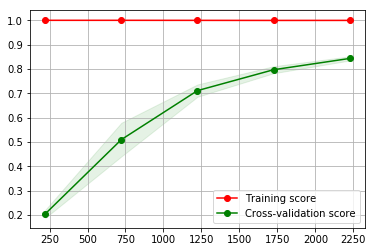

In [14]:
full_rfc = RandomForestClassifier(n_estimators = 100)

train_sizes, train_scores, test_scores = learning_curve(full_rfc, X, y, cv=4)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")
plt.show()

In [ ]:
predictions = full_rfc.predict(test_dataset)
prediction_frame = pd.DataFrame({'RowId' : range(1, 341), 'prediction' : predictions})
write_file = 'output/submission.csv'
prediction_frame.to_csv(write_file, index = False)